In [49]:
import pandas as pd
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
from typing import List, Callable
from scipy import stats
import timeit
import copy
import os
import Hawkes as hk
from datetime import datetime as dt

In file included from /usr/local/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1948,
                 from /usr/local/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.pyxbld/temp.linux-x86_64-3.8/pyrex/Hawkes/Hawkes_C.c:746:
/usr/local/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [6]:
register_matplotlib_converters()
sns.set()

▶ All graphs should have a legend, a title, labeled x-axis and y-axis with units if applicable.  
▶ Don’t plot log of (physical) quantities. Please use log scales instead.  
Don’t leave plot randomly in the notebook without context. Please indicate question
numbers and comment on your results if necessary (especially if they are not what you
were expecting).  

Do not use seaborn.



TODO: adapt the legend with plt.legend, or put proper names during the computations.  
explain the graphs like in an article.

# Simulation of homogeneous Poisson Processes.

In [62]:
## list the files in the directory
data_files_list = os.listdir("Data/RENA.PA/")
data_files_list = [f for f in data_files_list if "trades" in f]
## import each day as a pandas DF in a dictionary
data_dict = {i : pd.read_csv("Data/RENA.PA/"+f, index_col = 0) for i,f in zip(range(len(data_files_list)),data_files_list) }

In [63]:
data_dict[0].head(10)

,ts,price,volume
0,2017-01-02 09:01:15.893,84.31,90
1,2017-01-02 09:01:15.893,84.31,10
2,2017-01-02 09:01:18.813,84.31,12
3,2017-01-02 09:01:52.432,84.31,38
4,2017-01-02 09:01:52.452,84.31,62
5,2017-01-02 09:02:59.009,84.29,60
6,2017-01-02 09:02:59.009,84.29,64
7,2017-01-02 09:03:49.157,84.29,11
8,2017-01-02 09:05:11.114,84.23,1
9,2017-01-02 09:06:15.871,84.29,25


In [64]:
for _, df in data_dict.items():
    df['ts'] = pd.to_datetime(df["ts"])

In [65]:
num_days = 4

In [66]:
df_t= data_dict[0] # TODO change

In [69]:
df = pd.DataFrame({'date1':pd.date_range('2015-01-01', periods=3),
                   'date2':pd.date_range('2015-01-01 02:00:00', periods=3, freq='23H')})

In [70]:
df['diff'] = df['date2'] - df['date1']
df['seconds'] = df['diff'].dt.total_seconds()

In [71]:
df.dtypes

date1       datetime64[ns]
date2       datetime64[ns]
diff       timedelta64[ns]
seconds            float64
dtype: object

In [74]:
df

,date1,date2,diff,seconds
0,2015-01-01,2015-01-01 02:00:00,0 days 02:00:00,7200.0
1,2015-01-02,2015-01-02 01:00:00,0 days 01:00:00,3600.0
2,2015-01-03,2015-01-03 00:00:00,0 days 00:00:00,0.0


In [75]:
df_t.head()

,ts,price,volume
0,2017-01-02 09:01:15.893,84.31,90
1,2017-01-02 09:01:15.893,84.31,10
2,2017-01-02 09:01:18.813,84.31,12
3,2017-01-02 09:01:52.432,84.31,38
4,2017-01-02 09:01:52.452,84.31,62


In [76]:
df_t.dtypes

ts        datetime64[ns]
price            float64
volume             int64
dtype: object

In [78]:
initial_time = df_t.iloc[0,0]
initial_time

Timestamp('2017-01-02 09:01:15.893000')

In [82]:
df_t['diff'] = df_t['ts'] - initial_time
df_t.head(2)

,ts,price,volume,events,diff
0,2017-01-02 09:01:15.893,84.31,90,0 days,0 days
1,2017-01-02 09:01:15.893,84.31,10,0 days,0 days


In [83]:
df_t.dtypes

ts         datetime64[ns]
price             float64
volume              int64
events    timedelta64[ns]
diff      timedelta64[ns]
dtype: object

In [86]:
df_t['events'] = df_t['diff'].dt.total_seconds()

In [88]:
df_t.head(20)

,ts,price,volume,events,diff
0,2017-01-02 09:01:15.893,84.31,90,0.000,0 days 00:00:00
1,2017-01-02 09:01:15.893,84.31,10,0.000,0 days 00:00:00
2,2017-01-02 09:01:18.813,84.31,12,2.920,0 days 00:00:02.920000
3,2017-01-02 09:01:52.432,84.31,38,36.539,0 days 00:00:36.539000
4,2017-01-02 09:01:52.452,84.31,62,36.559,0 days 00:00:36.559000
5,2017-01-02 09:02:59.009,84.29,60,103.116,0 days 00:01:43.116000
6,2017-01-02 09:02:59.009,84.29,64,103.116,0 days 00:01:43.116000
7,2017-01-02 09:03:49.157,84.29,11,153.264,0 days 00:02:33.264000
8,2017-01-02 09:05:11.114,84.23,1,235.221,0 days 00:03:55.221000
9,2017-01-02 09:06:15.871,84.29,25,299.978,0 days 00:04:59.978000


In [89]:
T_i = df_t['events'].values
T_i

array([0.0000000e+00, 0.0000000e+00, 2.9200000e+00, ..., 3.0523078e+04,
       3.0523078e+04, 3.0523146e+04])

In [98]:
T_i.astype(np.float32)

array([0.0000000e+00, 0.0000000e+00, 2.9200001e+00, ..., 3.0523078e+04,
       3.0523078e+04, 3.0523146e+04], dtype=float32)

## Fit

In [99]:
model = hk.estimator()

In [100]:
model.set_kernel('exp', num_exp = 1)

In [101]:
model.set_baseline('const')

In [102]:
len(T_i)

2380

In [104]:
itv = [T_i[0], T_i[20]] # the observation interval
model.fit(T_i[:20],itv) # T is the event times (numpy.ndarray)

In [105]:
print("parameter:",model.parameter) # the estimated parameter values
print("branching ratio:",model.br) # the branching ratio
print("log-likelihood:",model.L) # the log-likelihood of the estimated parameter values
print("AIC:",model.AIC) # the AIC of the estimated parameter values

parameter: {'mu': 0.022442608635094338, 'alpha': 0.36789360528918047, 'beta': 333.53422990893665}
branching ratio: 0.36789360528918047
log-likelihood: -29.852671166759126
AIC: 65.70534233351825


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

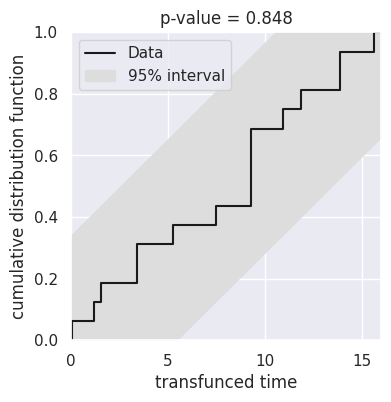

In [106]:
# T_trans: a list of transformed event occurrence times, itv_trans: the transformed observation interval
[T_trans, itv_trans] = model.t_trans() 
# Kormogorov-Smirnov test under the null hypothesis that the transformed event occurrence times are uniformly distributed
model.plot_KS() 

In [107]:
[T_trans, itv_trans]

[array([ 0.06553242,  1.18792408,  1.55580022,  3.41787285,  3.41787285,
         5.279112  ,  7.48633448,  9.30754409,  9.30754409,  9.30754409,
         9.30754409, 10.92836186, 11.86692612, 13.90336035, 13.90336035,
        15.64498039]),
 [0, 16.000000527291647]]

Faire tendre T vers l'infini et voir les estimateurs convergent bien sur les plusieurs jours etudiés

# 2\ Systematic analysis

resortir un disctionnaire et sauvegarder le csv, ne pas refitter 50 fois c long

In [ ]:
def estimate_parameters()